<a href="https://colab.research.google.com/github/chiarasaini/CNN-for-image-recognition-/blob/main/Leaves_images_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [2]:
import zipfile
import pandas as pd
import cv2 
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import os
from PIL import Image
import seaborn as sns
import pickle 
from tqdm import tqdm
import sklearn
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.utils import to_categorical

In [4]:
from google.colab import drive 
drive.mount('/content/drive') # Mount google drive

Mounted at /content/drive


#Import dataset from Kaggle

In [9]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [10]:
!mkdir -p /root/.kaggle
!cp /content/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
 # Import Kaggle
import kaggle

In [12]:
# Authenticate Kaggle API
kaggle.api.authenticate()


In [13]:
# Select the dataset
datasets = !kaggle datasets list -s "Plant Leaves image classification"
datasets

["Warning: Your Kaggle API key is readable by other users on this system! To fix this, you can run 'chmod 600 /content/kaggle.json'",
 'ref                                                         title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  ',
 '----------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  ',
 'csafrit2/plant-leaves-for-image-classification              Plant Leaves for Image Classification          7GB  2022-09-12 03:16:00            779         26  0.875            ',
 'vbookshelf/rice-leaf-diseases                               Rice Leaf Diseases Dataset                    37MB  2020-02-21 01:35:02           7192        128  0.625            ',
 'sadmansakibmahi/plant-disease-expert                        Plant Disease Expert                           6GB  2023-02-28 18:13:28         

In [14]:
dataset = datasets[3].split()[0]
dataset

'csafrit2/plant-leaves-for-image-classification'

In [15]:
# Download the dataset
dataset = 'csafrit2/plant-leaves-for-image-classification'
kaggle.api.dataset_download_files(dataset)


In [16]:
# Extract the zip file to the current working directory (i.e., the root directory in Colab)
with zipfile.ZipFile('plant-leaves-for-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall()  # Extract to the current directory


#Set Working Directory

In [17]:
# Set directory
cfg_path = os.getcwd() #/content /content/Plants_2/images to predict

input_path_train=  "Plants_2/train"
input_path_valid= "Plants_2/valid"
input_path_test= "Plants_2/test"

train_path = os.path.join(cfg_path,input_path_train)
val_path = os.path.join(cfg_path,input_path_valid)
test_path = os.path.join(cfg_path,input_path_test)

# Retrive data from directory

In [18]:
# Set batch size and imag size
batch_size = 32 
im_size = 180 

In [19]:
# Set train, validation and test datasets
train = tf.keras.utils.image_dataset_from_directory(directory = train_path,
                                                       image_size=(im_size, im_size),
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=42, 
                                                       labels = 'inferred') 

val = tf.keras.utils.image_dataset_from_directory(directory = val_path,
                                                  image_size=(im_size, im_size),
                                                  batch_size=1,
                                                  shuffle=True,
                                                  seed=42,
                                                  labels = 'inferred')

test = tf.keras.utils.image_dataset_from_directory(test_path,
                                                   image_size=(im_size, im_size),
                                                   batch_size=1,
                                                   shuffle=True,
                                                   seed=42,
                                                   labels = 'inferred') 

Found 4274 files belonging to 22 classes.
Found 110 files belonging to 22 classes.
Found 110 files belonging to 22 classes.


In [20]:
# See the names and the length of the classes inside the train, validation and test datasets to check if they are equal to each other
class_names_train = train.class_names
print(class_names_train)
print(len(class_names_train))

class_names_val = val.class_names
print(class_names_val)
print(len(class_names_val))

class_names_test = test.class_names
print(class_names_test)
print(len(class_names_test))


['Alstonia Scholaris diseased (P2a)', 'Alstonia Scholaris healthy (P2b)', 'Arjun diseased (P1a)', 'Arjun healthy (P1b)', 'Bael diseased (P4b)', 'Basil healthy (P8)', 'Chinar diseased (P11b)', 'Chinar healthy (P11a)', 'Gauva diseased (P3b)', 'Gauva healthy (P3a)', 'Jamun diseased (P5b)', 'Jamun healthy (P5a)', 'Jatropha diseased (P6b)', 'Jatropha healthy (P6a)', 'Lemon diseased (P10b)', 'Lemon healthy (P10a)', 'Mango diseased (P0b)', 'Mango healthy (P0a)', 'Pomegranate diseased (P9b)', 'Pomegranate healthy (P9a)', 'Pongamia Pinnata diseased (P7b)', 'Pongamia Pinnata healthy (P7a)']
22
['Alstonia Scholaris diseased (P2a)', 'Alstonia Scholaris healthy (P2b)', 'Arjun diseased (P1a)', 'Arjun healthy (P1b)', 'Bael diseased (P4b)', 'Basil healthy (P8)', 'Chinar diseased (P11b)', 'Chinar healthy (P11a)', 'Gauva diseased (P3b)', 'Gauva healthy (P3a)', 'Jamun diseased (P5b)', 'Jamun healthy (P5a)', 'Jatropha diseased (P6b)', 'Jatropha healthy (P6a)', 'Lemon diseased (P10b)', 'Lemon healthy (P10a

In [21]:
# Set plot stile to 'fivethirtyeight' for a nicer visualization
plt.style.use('fivethirtyeight')

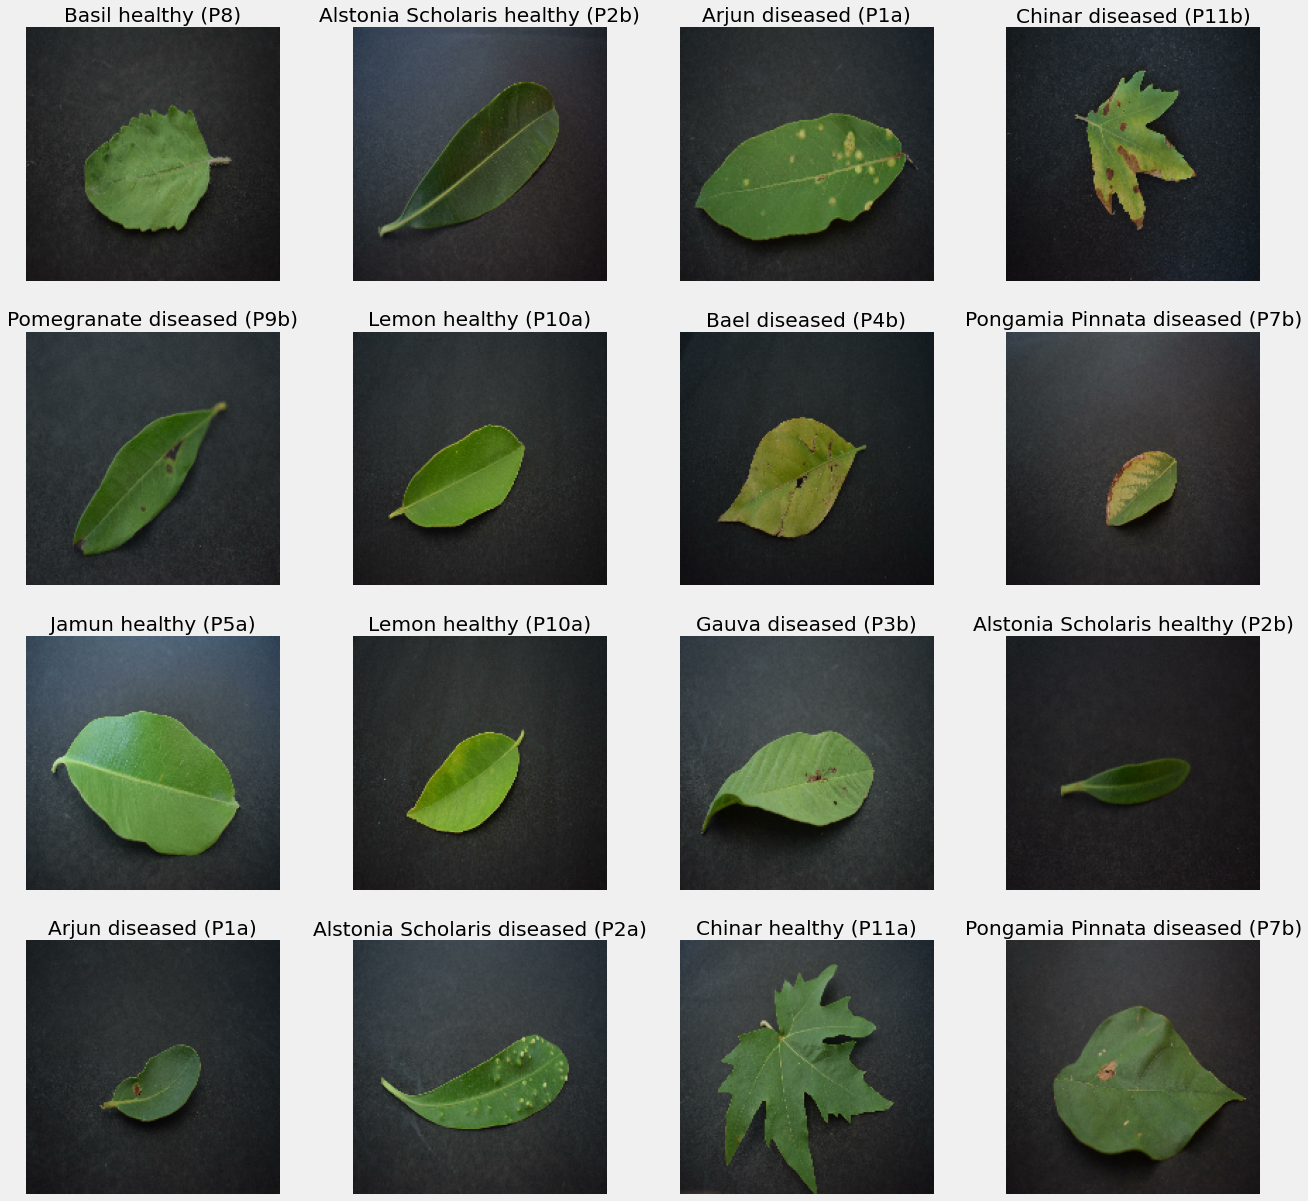

In [22]:
# Plot some images of the train set
plt.figure(figsize=(20, 20))
for images, labels in train.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names_train[labels[i]])
        plt.axis("off")

In [23]:
# See the count for each class for train set
train_unbatched = tuple(train.unbatch())
labels = []
for (image,label) in train_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)
counts = labels.value_counts()
print(counts)


10    335
21    312
19    277
11    268
9     267
20    265
18    261
16    255
0     244
2     222
3     210
1     168
17    159
15    149
5     137
8     131
13    123
12    114
6     110
4     107
7      93
14     67
dtype: int64


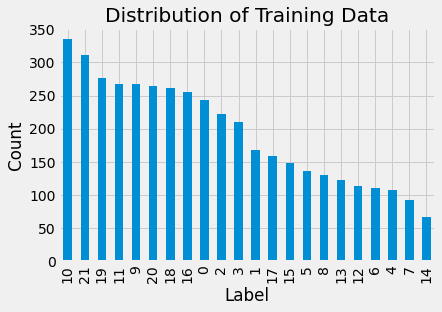

In [24]:
# Visualize the count for each class of the train set in a plot
counts.plot.bar()
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Training Data')

plt.show()

In [25]:
# See the count for each class of the validartion set
val_unbatched = tuple(val.unbatch())
labels_val = []
for (image,label) in val_unbatched:
    labels_val.append(label.numpy())
labels_val = pd.Series(labels_val)
counts_val = labels_val.value_counts()
print(counts_val)

2     5
19    5
10    5
21    5
7     5
1     5
18    5
17    5
4     5
9     5
11    5
5     5
8     5
3     5
14    5
15    5
12    5
0     5
13    5
16    5
6     5
20    5
dtype: int64


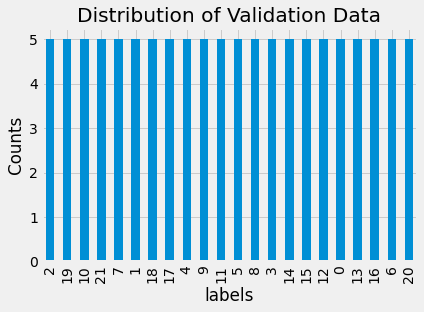

In [26]:
# Visualize the count for each class of the validation set in a plot
counts_val.plot.bar()
plt.xlabel('labels')
plt.ylabel('Counts')
plt.title('Distribution of Validation Data')

plt.show()

In [27]:
# See the count for each class of the test set
test_unbatched = tuple(test.unbatch())
labels_test = []
for (image,label) in test_unbatched:
    labels_test.append(label.numpy())
labels_test = pd.Series(labels_test)
counts_test = labels_test.value_counts()
print(counts_test)

2     5
19    5
10    5
21    5
7     5
1     5
18    5
17    5
4     5
9     5
11    5
5     5
8     5
3     5
14    5
15    5
12    5
0     5
13    5
16    5
6     5
20    5
dtype: int64


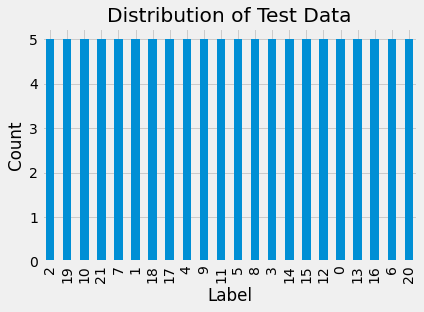

In [28]:
# Visualize the count for each class of the test set in a plot
counts_test.plot.bar()
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Test Data')

plt.show()

# Set weights for each class in trainig set because of imbalanced data



In [30]:
# Calculate class weights for training set using sklearn utils method
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(labels),
                                        y = labels                                                    
                                    )

# Create a dictionary for class weights for the models fitting
class_weights = dict(zip(np.unique(labels), class_weights))
class_weights

{0: 0.7961997019374069,
 1: 1.1563852813852813,
 2: 0.8751023751023751,
 3: 0.9251082251082251,
 4: 1.8156329651656755,
 5: 1.418049104180491,
 6: 1.7661157024793388,
 7: 2.088954056695992,
 8: 1.482997918112422,
 9: 0.7276132107592782,
 10: 0.5799185888738128,
 11: 0.7248982360922659,
 12: 1.70414673046252,
 13: 1.5794530672579452,
 14: 2.8995929443690636,
 15: 1.303843807199512,
 16: 0.7618538324420677,
 17: 1.2218410520297314,
 18: 0.744339951236503,
 19: 0.7013455858221201,
 20: 0.7331046312178388,
 21: 0.6226689976689976}

# NEURAL NETWORK MODELS

# model 1

In [103]:
# Building a CNN model 
model_1 = Sequential()
model_1.add(layers.Conv2D(16, 7, padding='same', activation='relu', input_shape = (im_size,im_size,3)))
model_1.add(layers.MaxPooling2D())
model_1.add(layers.Conv2D(32, 5, padding='same', activation='relu', input_shape = (im_size,im_size,3)))
model_1.add(layers.MaxPooling2D())
model_1.add(layers.Dense(128, activation='relu'))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(22))
model_1.add(layers.Softmax())


In [104]:
# Model summary
model_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 180, 180, 16)      2368      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 90, 90, 32)        12832     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 dense_22 (Dense)            (None, 45, 45, 128)       4224      
                                                                 
 dropout_6 (Dropout)         (None, 45, 45, 128)     

In [105]:
print("Number of layers in the model: ", len(model_1.layers))
print("Number of parameters in the model: ", model_1.count_params()) 

Number of layers in the model:  10
Number of parameters in the model:  2878902


In [106]:
# Setting callbacks
from keras.callbacks import ReduceLROnPlateau

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2, 
    mode='min', 
    restore_best_weights=True, 
    start_from_epoch=0 )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=2, min_lr=0.001)

checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [107]:
# Model compiling
model_1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy']) 

In [108]:
# Model fitting
history_1 = model_1.fit(train, validation_data=val, epochs=10, batch_size=32, callbacks = [early_stop, reduce_lr])

Epoch 1/10
134/134 [==============================] - 48s 321ms/step - loss: 9.9230 - accuracy: 0.0849 - val_loss: 3.0603 - val_accuracy: 0.0818 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 45s 315ms/step - loss: 2.7004 - accuracy: 0.1509 - val_loss: 2.7402 - val_accuracy: 0.2091 - lr: 0.0010
Epoch 3/10
134/134 [==============================] - 45s 317ms/step - loss: 2.3899 - accuracy: 0.2489 - val_loss: 2.5387 - val_accuracy: 0.1364 - lr: 0.0010
Epoch 4/10
134/134 [==============================] - 45s 315ms/step - loss: 2.2696 - accuracy: 0.2730 - val_loss: 2.5512 - val_accuracy: 0.2273 - lr: 0.0010
Epoch 5/10
134/134 [==============================] - 45s 315ms/step - loss: 2.1885 - accuracy: 0.3009 - val_loss: 2.5113 - val_accuracy: 0.2364 - lr: 0.0010
Epoch 6/10
134/134 [==============================] - 45s 314ms/step - loss: 2.1128 - accuracy: 0.3252 - val_loss: 2.5457 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 7/10
134/134 [==============================] 

In [99]:
# Defining plot and accuracy curves 
def plot_loss_curves(history_1):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=history_1.history['loss']
    val_loss=history_1.history['val_loss']

    train_accuracy=history_1.history['accuracy']
    val_accuracy=history_1.history['val_accuracy']

    epochs=range(1,len(history_1.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

In [ ]:
plot_loss_curves(history_1)

In [ ]:
# Predict 
true = []
predicted_1 = []

for img, label in tqdm(test):
  pred = model_1.predict(img, verbose = 0)
  pred = pred.argmax(-1)
  true.append(label[0])
  predicted_1.append(pred[0])


In [72]:
sklearn.metrics.f1_score(true, predicted_1, average = 'macro')

0.5055063623245442

# Tensorboard

In [29]:
# Import packages for tensorboard
import time
from tensorflow.keras.callbacks import TensorBoard

In [30]:
%load_ext tensorboard

In [31]:
rm -rf ./logs/

In [33]:
NAME = 'plant-leaves-cnn{}'.format(int(time.time()))

In [34]:
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [32]:
# Setting parameters for Tensorboard
dense_layers = np.arange(0, 4, 1)
layer_sizes = np.arange(32, 256, 32) #8 to 128
conv_layers = [3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

3-conv-32-nodes-0-dense-1678879196
3-conv-64-nodes-0-dense-1678879196
3-conv-96-nodes-0-dense-1678879196
3-conv-128-nodes-0-dense-1678879196
3-conv-160-nodes-0-dense-1678879196
3-conv-192-nodes-0-dense-1678879196
3-conv-224-nodes-0-dense-1678879196
3-conv-32-nodes-1-dense-1678879196
3-conv-64-nodes-1-dense-1678879196
3-conv-96-nodes-1-dense-1678879196
3-conv-128-nodes-1-dense-1678879196
3-conv-160-nodes-1-dense-1678879196
3-conv-192-nodes-1-dense-1678879196
3-conv-224-nodes-1-dense-1678879196
3-conv-32-nodes-2-dense-1678879196
3-conv-64-nodes-2-dense-1678879196
3-conv-96-nodes-2-dense-1678879196
3-conv-128-nodes-2-dense-1678879196
3-conv-160-nodes-2-dense-1678879196
3-conv-192-nodes-2-dense-1678879196
3-conv-224-nodes-2-dense-1678879196
3-conv-32-nodes-3-dense-1678879196
3-conv-64-nodes-3-dense-1678879196
3-conv-96-nodes-3-dense-1678879196
3-conv-128-nodes-3-dense-1678879196
3-conv-160-nodes-3-dense-1678879196
3-conv-192-nodes-3-dense-1678879196
3-conv-224-nodes-3-dense-1678879196


In [ ]:
# Building model
dense_layers = np.arange(0, 4, 1)
layer_sizes = np.arange(32, 256, 32)
conv_layers = [3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model_t = Sequential()
            model_t.add(tf.keras.layers.RandomFlip("horizontal",input_shape=(im_size,im_size,3)))
            model_t.add(tf.keras.layers.RandomFlip("vertical"))
            model_t.add(tf.keras.layers.RandomRotation(0.5))
            model_t.add(tf.keras.layers.RandomZoom(0.5))
            model_t.add(tf.keras.layers.Rescaling(1./255))
            model_t.add(Conv2D(layer_size, (3, 3), input_shape=(im_size, im_size, 3)))
            model_t.add(Activation('relu'))
            model_t.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model_t.add(Conv2D(layer_size, (3, 3)))
                model_t.add(Activation('relu'))
                model_t.add(MaxPooling2D(pool_size=(2, 2)))

            model_t.add(Flatten())

            for _ in range(dense_layer):
                model_t.add(Dense(layer_size))
                model_t.add(Activation('relu'))

            model_t.add(Dense(22))
            model_t.add(Activation('softmax'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model_t.compile(loss='sparse_categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            fit_t = model_t.fit(train,
                      batch_size=32,
                      epochs=10,
                      validation_data=val,
                      callbacks=[tensorboard], # Tensorboard callbacks
                      class_weight = class_weights)

In [ ]:
%tensorboard --logdir logs/

# Model t1


In [53]:
# Building model
model_t1 = Sequential()
model_t1.add(tf.keras.layers.RandomFlip("horizontal",input_shape=(im_size,im_size,3)))
model_t1.add(tf.keras.layers.RandomFlip("vertical"))
model_t1.add(tf.keras.layers.RandomRotation(0.5))
model_t1.add(tf.keras.layers.RandomZoom(0.5))
model_t1.add(tf.keras.layers.Rescaling(1./255))

model_t1.add(Conv2D(192, (3, 3), input_shape=(im_size, im_size, 3)))
model_t1.add(Activation('relu'))
model_t1.add(MaxPooling2D(pool_size=(2, 2)))

model_t1.add(Conv2D(192, (3, 3), input_shape=(im_size, im_size, 3)))
model_t1.add(Activation('relu'))
model_t1.add(MaxPooling2D(pool_size=(2, 2)))

model_t1.add(Conv2D(192, (3, 3), input_shape=(im_size, im_size, 3)))
model_t1.add(Activation('relu'))
model_t1.add(MaxPooling2D(pool_size=(2, 2)))

model_t1.add(Flatten())

model_t1.add(Dense(192))
model_t1.add(Activation('relu'))

model_t1.add(Dense(22))
model_t1.add(Activation('softmax'))

In [54]:
# Model summary
model_t1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 192)     5376      
                                                      

In [55]:
print("Number of layers in the model: ", len(model_t1.layers))
print("Number of parameters in the model: ", model_t1.count_params()) 

Number of layers in the model:  19
Number of parameters in the model:  15419350


In [57]:
# Model compile 
model_t1.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) 

In [58]:
# Model fitting 
history_t1 = model_t1.fit(train, validation_data=val, epochs=10, batch_size=32, callbacks = [early_stop, reduce_lr, model_checkpoint_callback], class_weight = class_weights)

Epoch 1/10


134/134 [==============================] - 53s 328ms/step - loss: 2.8173 - accuracy: 0.1350 - val_loss: 2.2534 - val_accuracy: 0.3091 - lr: 0.0010
Epoch 2/10
134/134 [==============================] - 49s 345ms/step - loss: 2.1154 - accuracy: 0.3257 - val_loss: 1.7362 - val_accuracy: 0.3909 - lr: 0.0010
Epoch 3/10
134/134 [==============================] - 49s 345ms/step - loss: 1.7768 - accuracy: 0.4263 - val_loss: 1.6553 - val_accuracy: 0.4545 - lr: 0.0010
Epoch 4/10
134/134 [==============================] - 49s 341ms/step - loss: 1.5494 - accuracy: 0.5082 - val_loss: 1.7345 - val_accuracy: 0.3909 - lr: 0.0010
Epoch 5/10
134/134 [==============================] - 49s 344ms/step - loss: 1.3385 - accuracy: 0.5810 - val_loss: 1.5076 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/10
134/134 [==============================] - 49s 346ms/step - loss: 1.1622 - accuracy: 0.6313 - val_loss: 1.6599 - val_accuracy: 0.5091 - lr: 0.0010
Epoch 7/10
134/134 [==============================] - 49s 345ms

In [65]:
# Defining plot and accuracy curves 
def plot_loss_curves(history_t1):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=history_t1.history['loss']
    val_loss=history_t1.history['val_loss']

    train_accuracy=history_t1.history['accuracy']
    val_accuracy=history_t1.history['val_accuracy']

    epochs=range(1,len(history_t1.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

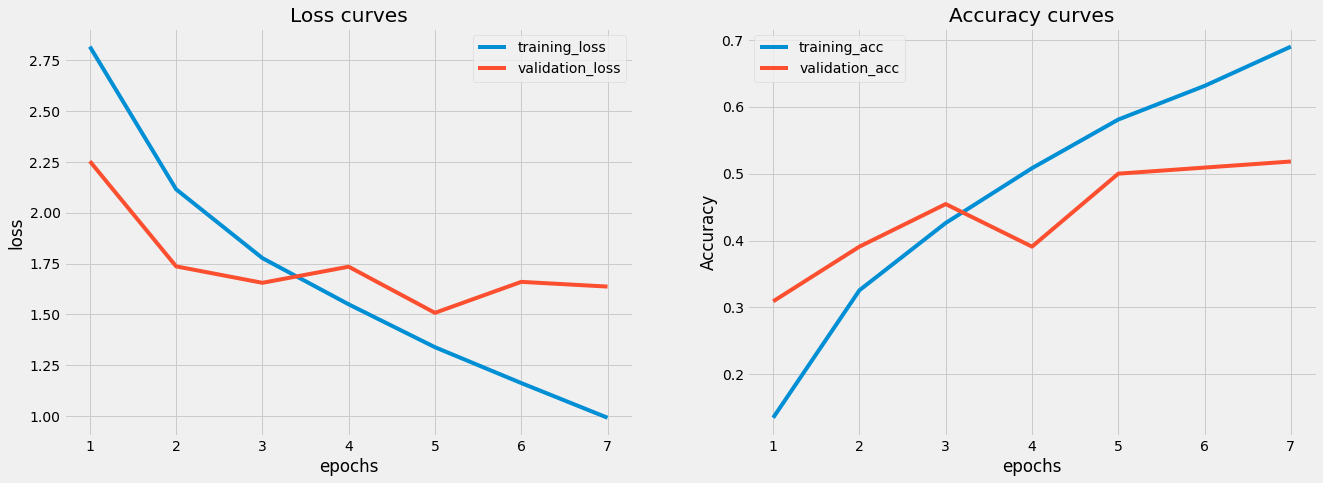

In [60]:
plot_loss_curves(history_t1)

In [61]:
# Predict 
true = []
predicted = []

for img, label in tqdm(test):
  pred = model_t1.predict(img, verbose = 0)
  pred = pred.argmax(-1)
  true.append(label[0])
  predicted.append(pred[0])

100%|██████████| 110/110 [00:06<00:00, 17.43it/s]


In [62]:
sklearn.metrics.f1_score(true, predicted, average = 'macro')

0.5225007315916407

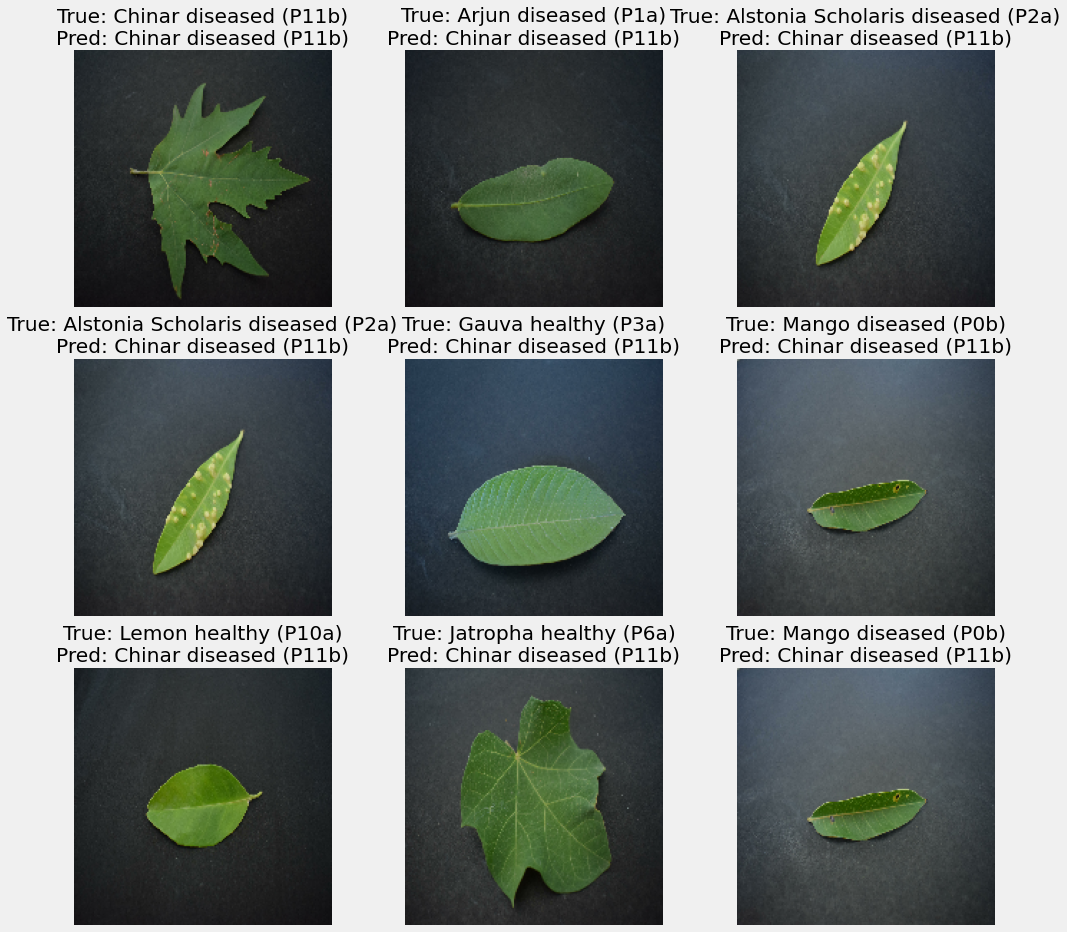

In [67]:
# Plotting predicted labels VS true abels
plt.figure(figsize=(15,15))
for i in range(9): 
  plt.subplot(3,3,i+1)
  batch = list(test.take(1))
  img, label = batch[0]
  pred = model_t1.predict(img, verbose=False).argmax(-1) 
  plt.imshow(img[0].numpy().astype(int))
  plt.title(f"True: {class_names_train[label[0]]}\nPred: {class_names_train[predicted[0]]}") 
  plt.axis('off')

plt.show()

# Model t3

In [31]:
# Set batch size and imag size
batch_size_t = 50 
im_size_t = 64 

In [32]:
# Set train, validation and test datasets
train_t = tf.keras.utils.image_dataset_from_directory(directory = train_path,
                                                       image_size=(im_size_t, im_size_t),
                                                       batch_size=batch_size_t,
                                                       shuffle=True,
                                                       seed=42, 
                                                       labels = 'inferred') 

val_t = tf.keras.utils.image_dataset_from_directory(directory = val_path,
                                                  image_size=(im_size_t, im_size_t),
                                                  batch_size=1,
                                                  shuffle=True,
                                                  seed=42,
                                                  labels = 'inferred')

test_t = tf.keras.utils.image_dataset_from_directory(test_path,
                                                   image_size=(im_size_t, im_size_t),
                                                   batch_size=1,
                                                   shuffle=True,
                                                   seed=42,
                                                   labels = 'inferred') 

Found 4274 files belonging to 22 classes.
Found 110 files belonging to 22 classes.
Found 110 files belonging to 22 classes.


In [155]:
# Building a CNN model 
model_q = Sequential()
model_q.add(Conv2D(96, (3, 3), activation = 'relu', input_shape=(im_size_t, im_size_t, 3)))
model_q.add(MaxPooling2D(pool_size=(2, 2)))
model_q.add(layers.BatchNormalization())
model_q.add(MaxPooling2D(pool_size=(2, 2)))
model_q.add(Conv2D(160, (3, 3), activation = 'relu', input_shape=(im_size_t, im_size_t, 3)))
model_q.add(MaxPooling2D(pool_size=(2, 2)))
model_q.add(Dropout(0.2))
model_q.add(Dense(64, activation='relu'))
model_q.add(Flatten())
model_q.add(Dense(22))
model_q.add(Activation('softmax'))

In [156]:
# Model summary
model_q.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 62, 62, 96)        2688      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 31, 31, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 31, 31, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 15, 15, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 13, 13, 160)       138400    
                                                     

In [157]:
print("Number of layers in the model: ", len(model_q.layers))
print("Number of parameters in the model: ", model_q.count_params()) 

Number of layers in the model:  11
Number of parameters in the model:  202486


In [158]:
# Model compiling
opt = keras.optimizers.Adam(learning_rate=0.001)
model_q.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [159]:
# Model fitting
history_q = model_q.fit(train_t, validation_data=val_t, epochs=10, batch_size=32, class_weight = class_weights, callbacks = [early_stop, reduce_lr, model_checkpoint_callback])

Epoch 1/10
86/86 [==============================] - 46s 466ms/step - loss: 1.6267 - accuracy: 0.5213 - val_loss: 3.8725 - val_accuracy: 0.1636 - lr: 0.0010
Epoch 2/10
86/86 [==============================] - 45s 470ms/step - loss: 0.7368 - accuracy: 0.7740 - val_loss: 1.3912 - val_accuracy: 0.5909 - lr: 0.0010
Epoch 3/10
86/86 [==============================] - 44s 466ms/step - loss: 0.4532 - accuracy: 0.8650 - val_loss: 1.2438 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 4/10
86/86 [==============================] - 45s 469ms/step - loss: 0.4047 - accuracy: 0.8638 - val_loss: 1.3433 - val_accuracy: 0.6273 - lr: 0.0010
Epoch 5/10
86/86 [==============================] - 45s 469ms/step - loss: 0.2864 - accuracy: 0.9010 - val_loss: 1.4692 - val_accuracy: 0.5909 - lr: 0.0010


In [160]:
# Defining plot and accuracy curves 
def plot_loss_curves(history_q):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=history_q.history['loss']
    val_loss=history_q.history['val_loss']

    train_accuracy=history_q.history['accuracy']
    val_accuracy=history_q.history['val_accuracy']

    epochs=range(1,len(history_q.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

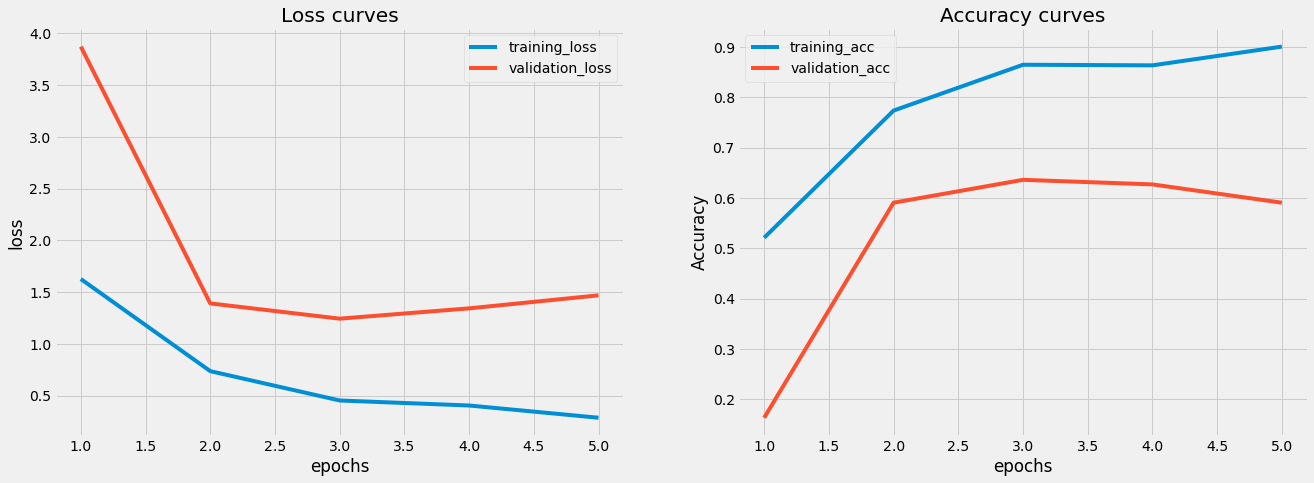

In [161]:
plot_loss_curves(history_q)

In [162]:
# Predict 
true = []
predicted_q = []

for img, label in tqdm(test_t):
  pred = model_q.predict(img, verbose = 0)
  pred = pred.argmax(-1)
  true.append(label[0])
  predicted_q.append(pred[0])

100%|██████████| 110/110 [00:06<00:00, 16.36it/s]


In [163]:
# F1 score
sklearn.metrics.f1_score(true, predicted_q, average = 'macro')

0.7527712186803096

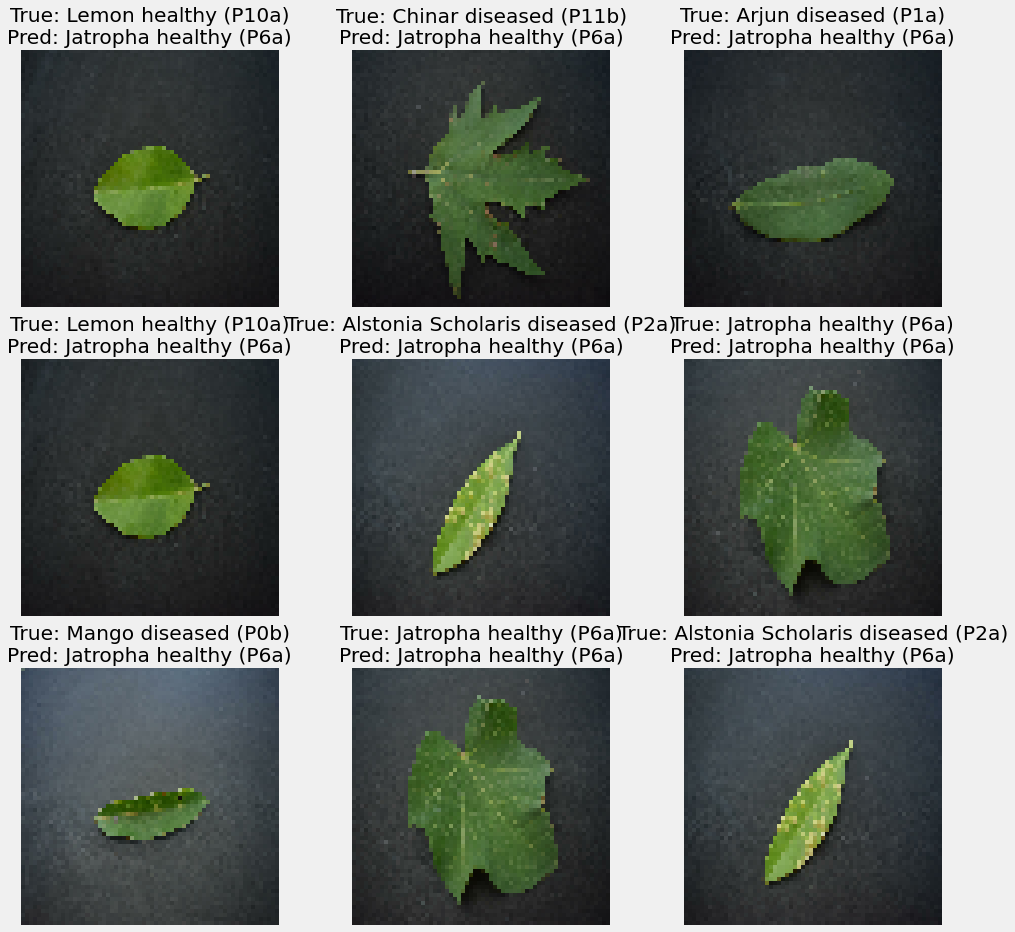

In [164]:
# Plotting predicted labels VS true abels
plt.figure(figsize=(15,15))
for i in range(9): 
  plt.subplot(3,3,i+1)
  batch = list(test_t.take(1))
  img, label = batch[0]
  pred = model_q.predict(img, verbose=False).argmax(-1) 
  plt.imshow(img[0].numpy().astype(int))
  plt.title(f"True: {class_names_train[label[0]]}\nPred: {class_names_train[predicted_q[0]]}") 
  plt.axis('off')

plt.show()